


# Machine Learning and Time Series Forecasting
In the first part of this project [(part 1)](https://www.kaggle.com/code/sedimir/using-data-analytics-to-manage-a-solar-power-plant), we conducted an exploratory data analysis (EDA) on the power plant dataset. In the second part, our objective is to employ machine learning (ML) techniques to forecast power generation for the upcoming days. 


There are several steps involved in time series forecasting with machine learning (ML), including:

1. **data preparation**: cleaning and transforming the data
2. **feature engineering**: selecting or creating relevant features to train the model
3. **model selection**: choosing an appropriate algorithm or method to fit the time series data
4. **evaluation**: assessing the performance of the model on test data


Some of ML models specifically designed to handle time series data are:

* Autoregressive Integrated Moving Average (**ARIMA**): ARIMA is a widely used model for time series forecasting that considers the autoregressive (AR), integrated (I), and moving average (MA) components of the data. 

* Seasonal ARIMA (**SARIMA**): SARIMA extends the ARIMA model by incorporating seasonal components to account for seasonal patterns in time series data.

* Exponential Smoothing (**ES**): Exponential smoothing methods, such as Simple Exponential Smoothing (SES), Holt's Linear Exponential Smoothing (Holt-Winters), and Seasonal Exponential Smoothing (ETS), capture trends and seasonality in time series data. 
* Recurrent Neural Networks (**RNNs**): RNNs, specifically Long Short-Term Memory (LSTM) networks, are powerful ML models capable of capturing long-term dependencies in time series data.
* **Prophet**: Prophet is a forecasting framework developed by Facebook that utilizes an additive model to capture seasonality, trends, and other components in time series data.
* Gaussian Processes (**GPs**): GPs are a probabilistic approach for time series modeling, capable of capturing uncertainty and providing flexible regression and forecasting capabilities.
* Convolutional Neural Networks (**CNNs**): CNNs, commonly used in computer vision tasks, can also be applied to time series data by treating them as images or using one-dimensional convolutions to capture temporal patterns.
* Support Vector Regression (**SVR**): SVR is a regression technique that can be applied to time series data, leveraging support vector machines to find the best fit curve.
* State Space Models (**SSMs**): SSMs represent time series data as a combination of latent states and observations. They provide a flexible framework for modeling complex dependencies in time series.

It's important to note that the choice of procedure depends on the specific characteristics of the time series data and the forecasting task at hand.

## 1. Exploratoy Data Analysis (EDA) 

[Click to go the first part](https://www.kaggle.com/code/sedimir/using-data-analytics-to-manage-a-solar-power-plant)

## 2. Machine Learning: Forecasting Power Generation

In what follows, we will employ ARIMA and Prophet procedures independently to predict DC power in the next couple of days and compare their respective results. The workflow will follow the steps outlined below: 

    2.  1 Stationarity - Lag - Autocorrleation 
    2.  2 ARIMA
    2.  3 Prophet
    2.  4 Evaluation
    2.  5 Conclusion
    
    


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
import matplotlib.dates as mdates 

##reading genration dataset
custom_date_parser = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M') 
gen=pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv',index_col='DATE_TIME', parse_dates=['DATE_TIME'], date_parser=custom_date_parser)
gen.head(2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0





For the sake of simplicity we are going to limit our data to June 10th to June 15th. Using this data we are going to predict generation for June 16th and 17th and compare it with actual generation on these two days. 

In [2]:
train=gen['2020-06-11 00:00:00':'2020-06-16 00:00:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()
test=gen['2020-06-16 00:00:00':'2020-06-17 23:45:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()

<AxesSubplot: xlabel='DATE_TIME', ylabel='DC_POWER'>

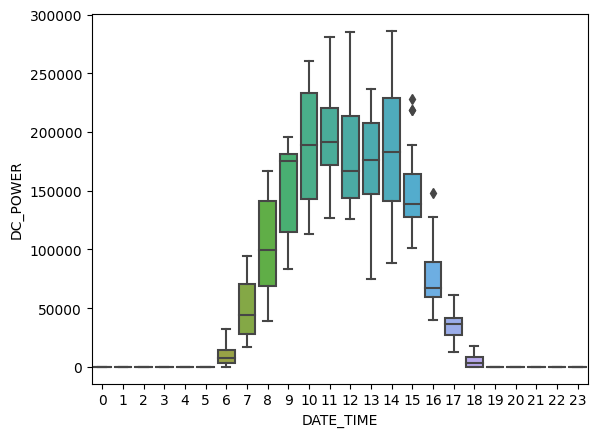

In [3]:
sns.boxplot(x=train.index.hour, y=train.DC_POWER)

The above plot show boxex that encompasses the middle 50% of the data between the 25th and 75th percentiles, with whiskers that extend to the minimum and maximum values. Any outliers beyond the whiskers are represented by individual dots. In this specific plot, the boxes are grouped by hour.

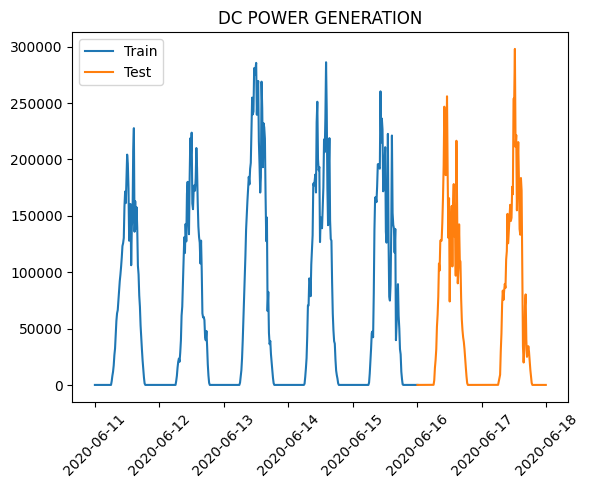

In [4]:
plt.plot(train.DC_POWER, label='Train')
plt.plot(test.DC_POWER,label='Test')
plt.xticks(rotation=45)
plt.title('DC POWER GENERATION')
plt.legend()
plt.show()


### 2.1  Stationarity - Lag - Autocorrleation 

#### **Stationarity**
For forecasting purposes, it is desirable for a time series to exhibit stationarity. In a stationary time series, the mean, variance, and covariance remain constant over time. Stationarity is important because it allows us to make reliable predictions based on the assumption that the future behavior of the time series will be similar to its past behavior.

When a time series is non-stationary, it may exhibit trends, seasonality, or other patterns that can make forecasting challenging. In such cases, it becomes necessary to transform the time series to achieve stationarity before applying forecasting models.

Common techniques for achieving stationarity include taking first differences to remove trends or applying transformations such as logarithmic to stabilize the variance. Once stationarity is achieved, forecasting models can be effectively applied to make accurate predictions.

By ensuring stationarity in a time series, we can rely on the assumption that the statistical properties of the series will remain consistent, enabling us to generate reliable forecasts for future observations.


There are several statistical tests available to determine the stationarity of a time series. Here we are going to use Augmented Dickey-Fuller (ADF) Test. The ADF tests the null hypothesis that a unit root is present in the time series (indicating non-stationarity). A unit root implies that the autoregressive coefficient in the lagged values of the series is equal to 1. This means that the effect of past values on the current value of the time series does not decay over time. If the p-value obtained from the ADF test is below a chosen significance level (e.g., 0.05), we can reject the null hypothesis and conclude that the series is stationary.

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train.DC_POWER)
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

ADF Statistic: -5.0967458470422855
p-value: 1.4231761149149942e-05
Critical Values:
1%: -3.44455286264131
5%: -2.8678027030003483
10%: -2.5701057817594894


The *ADF statistic* quantifies the strength of evidence against non-stationarity (negative values mean a strong evidence which timeseries is probabely stationary), while the *p-value* provides the probability associated with that evidence. The Critical Values indicate different confidence levels at which the null hypothesis (non-stationarity) would be rejected.

In our case, the *ADF statistic* value is significantly negative, indicating strong evidence against the presence of a unit root (non-stationarity). Additionally, the *p-value* is very small (less than the commonly used significance level of 0.05), further supporting the rejection of the null hypothesis of a unit root and indicating the presence of stationarity.

Let's investigate the staionarity furthere using lag and autocorrelation.


**Lag and Autocorrelation**

For timeseries,lag refers to the time difference between observations in the series. It represents how far back in time you are looking when examining the relationship between observations.

Autocorrelation measures the linear relationship between an observation and its lagged values. It quantifies the degree of similarity or dependence between observations at different time points. Positive autocorrelation indicates that observations tend to be similar at higher lags, while negative autocorrelation indicates that observations tend to be dissimilar.

In a stationary time series, the autocorrelation between observations tends to decrease rapidly as the lag increases. Slowly diminishing autocorrelations can indicate non-stationarity, but it can also occur in certain stationary time series with long-term dependencies or trends.


Figure 1 and 2 below, clearly illustrate a positive correlation between two observations in the timeseries indicating that each observation is positively correlated by its preceding observation (Figure 1). This is a characteristic commonly observed in time series data, and it does not necessarily imply non-stationarity on its own. The autocorelations tend to be diminish slowly. It might be because of seasonality patterns in our timseries. 

To conclude, our time series exhibits non-stationary behavior. The slow decay of autocorrelations and the presence of seasonality patterns indicate the need for careful consideration when applying forecasting models like ARIMA. 


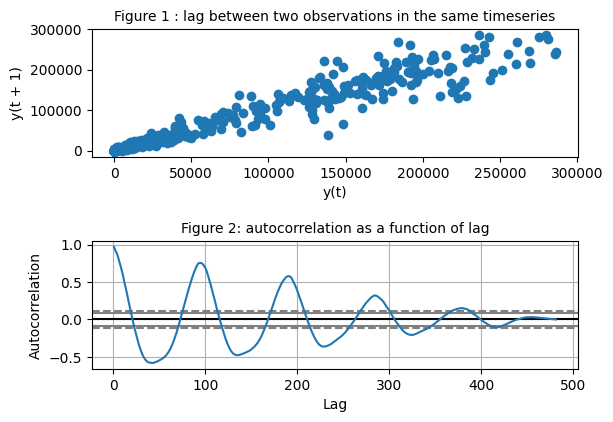

In [6]:
f,ax= plt.subplots(2,1)
plt.tight_layout(pad=4)
pd.plotting.lag_plot(train.DC_POWER, ax=ax[0])
pd.plotting.autocorrelation_plot(train.DC_POWER,ax=ax[1])
ax[0].set_title('Figure 1 : lag between two observations in the same timeseries', fontsize=10)
ax[1].set_title('Figure 2: autocorrelation as a function of lag',fontsize=10)

plt.show()


### 2.2 Prophet 

Prophet is a forecasting framework developed by Facebook's Core Data Science team. It is designed to provide a simple yet powerful tool for time series forecasting. Prophet incorporates several features that make it user-friendly and effective for forecasting tasks:

Automatic trend detection: Prophet can automatically detect and model various types of trends in time series data, including linear, logistic, and saturating growth trends. This capability makes it suitable for a wide range of time series datasets.

Seasonality modeling: Prophet includes built-in functionality to capture and model multiple seasonal patterns that may exist in the data. It can handle both daily and yearly seasonal components, as well as user-defined seasonalities.

Handling missing data and outliers: Prophet can handle missing data and outliers in a robust manner. It imputes missing values and identifies outliers using a piecewise linear or logistic regression model.

Flexibility in data input: Prophet accepts time series data in a specific format, with a timestamp column and an associated target variable column. This format allows for easy integration with various data sources and quick implementation.

Intuitive model diagnostics: Prophet provides diagnostic tools to evaluate the quality and performance of the forecast. These tools include visualizations that help users understand the model's fit to the historical data.

Customizable forecasting: While Prophet offers automatic trend and seasonality modeling, users can also incorporate their domain knowledge by specifying custom seasonalities or making adjustments to the model parameters.

Overall, Prophet simplifies the process of time series forecasting, making it accessible to a wider audience. It is particularly useful for datasets with clear trend and seasonal patterns, and it provides a solid baseline for forecasting tasks.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [7]:
from prophet import Prophet
train_pr=gen['2020-06-11 00:00:00':'2020-06-15 23:45:00'].drop('SOURCE_KEY',axis=1).DC_POWER.groupby('DATE_TIME').sum().reset_index()
test_pr=gen['2020-06-15 23:45:00':'2020-06-17 23:45:00'].drop('SOURCE_KEY',axis=1).DC_POWER.groupby('DATE_TIME').sum()

train_pr.columns=['ds','y']
model=Prophet()
model.fit(train_pr)

01:06:03 - cmdstanpy - INFO - Chain [1] start processing
01:06:03 - cmdstanpy - INFO - Chain [1] done processing


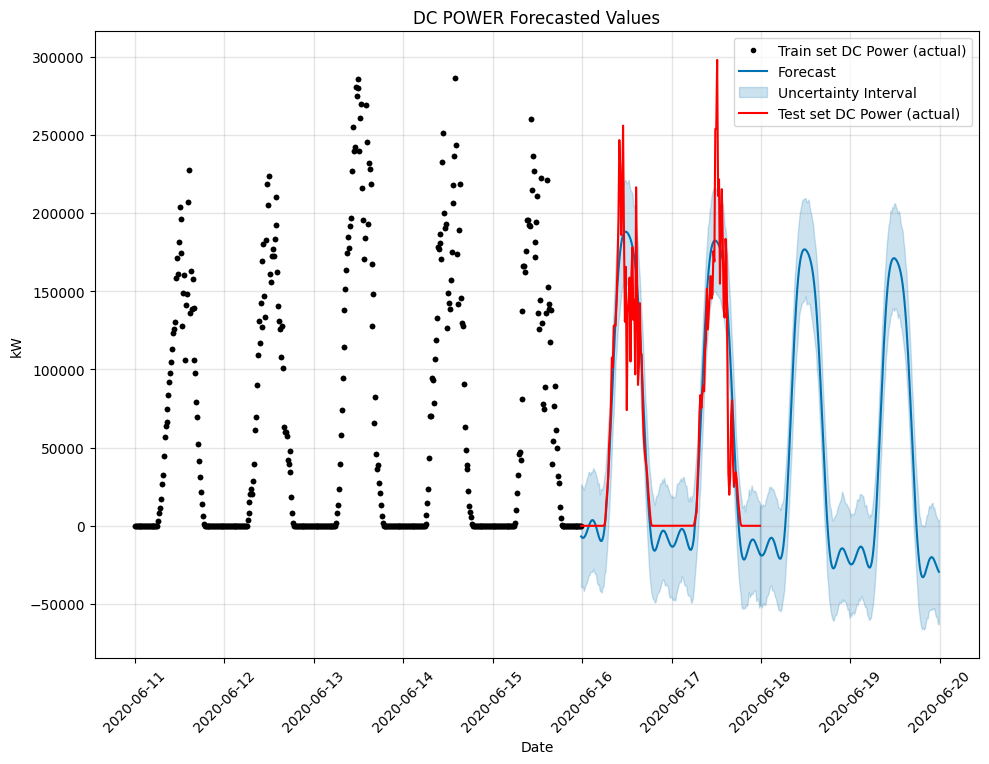

In [8]:
test_dates=pd.DataFrame(test_pr.index).rename(columns={'DATE_TIME':'ds'})
forecast_test=model.predict(test_dates)

dates=pd.date_range(start='2020-06-17 23:45:00',end='2020-06-19 23:45:00',freq=pd.DateOffset(minutes=15))
future_dates=pd.DataFrame(dates,columns=['ds'])
forecast_future=model.predict(future_dates)

plt.figure(figsize=(10,7))
fig1=model.plot(forecast_test,ax=plt.gca())
fig1=model.plot(forecast_future,ax=plt.gca())
fig2=plt.plot(test_pr,'r-', label='Actual from test set')

handles1, labels1 = fig1.gca().get_legend_handles_labels()
handles=handles1[0:3]+fig2
labels1 =['Train set DC Power (actual)', 'Forecast', 'Uncertainty Interval','Test set DC Power (actual)']

fig1.gca().legend(handles, labels1,loc='upper right')
plt.xlabel('Date')
plt.ylabel('kW')
plt.title('DC POWER Forecasted Values')
plt.xticks(rotation=45)
plt.show()

###  2.3 Autoregressive Integrated Moving Average (ARIMA)

Determining the optimal values for the parameters p, d, and q in an ARIMA model is an important step in time series analysis. These parameters represent the autoregressive (p), differencing (d), and moving average (q) components of the model, respectively.

The selection of these parameters depends on the characteristics of your time series data. Our timeseries is stationary, therefore d=0 in ARIMA model (for non-stationary timesereis: d=1). The autoregressive component (p) captures the relationship between the current observation and a specified number of lagged observations. The moving average component (q) considers the dependency between the current observation and a specified number of lagged forecast errors.

To tune the parameters of an ARIMA model for a stationary time series, you can use the auto_arima function available in the pmdarima library in Python. This function automates the process of selecting the optimal p, d, and q values for the ARIMA model using a stepwise approach.



In [9]:
from pandas.tseries.offsets import DateOffset
! pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.8 MB/s eta 0:00:00


In [10]:
train_arima=gen['2020-06-13 00:00:00':'2020-06-16 00:00:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()
test_arima=gen['2020-06-16 00:00:00':'2020-06-17 23:45:00'].drop('SOURCE_KEY',axis=1).groupby('DATE_TIME').sum()

arima_model = auto_arima(train_arima.DC_POWER,
                         start_p=0,d=0,start_q=0,
                         max_p=2,max_d=0,max_q=2,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[96] intercept   : AIC=4623.848, Time=1.09 sec
 ARIMA(1,0,0)(1,1,0)[96] intercept   : AIC=4478.869, Time=22.02 sec
 ARIMA(0,0,1)(0,1,1)[96] intercept   : AIC=4498.071, Time=28.24 sec
 ARIMA(0,0,0)(0,1,0)[96]             : AIC=4641.102, Time=1.80 sec
 ARIMA(1,0,0)(0,1,0)[96] intercept   : AIC=4500.445, Time=1.13 sec
 ARIMA(1,0,0)(1,1,1)[96] intercept   : AIC=4476.612, Time=33.07 sec
 ARIMA(1,0,0)(0,1,1)[96] intercept   : AIC=4474.622, Time=24.88 sec
 ARIMA(0,0,0)(0,1,1)[96] intercept   : AIC=4589.492, Time=12.86 sec
 ARIMA(2,0,0)(0,1,1)[96] intercept   : AIC=4475.584, Time=41.80 sec
 ARIMA(1,0,1)(0,1,1)[96] intercept   : AIC=4472.357, Time=44.06 sec
 ARIMA(1,0,1)(0,1,0)[96] intercept   : AIC=4496.749, Time=3.62 sec
 ARIMA(1,0,1)(1,1,1)[96] intercept   : AIC=4474.108, Time=45.38 sec
 ARIMA(1,0,1)(1,1,0)[96] intercept   : AIC=4476.690, Time=31.09 sec
 ARIMA(2,0,1)(0,1,1)[96] intercept   : AIC=inf, Time=90.87 sec
 ARIMA(1,0,2)(

In [11]:
dates=pd.date_range(start=test_arima.index[0],end='2020-06-19 23:45:00',freq=pd.DateOffset(minutes=15))

prediction_test=pd.DataFrame(arima_model.predict(n_periods=len(dates)),index=dates)
prediction_test.columns=['predicted_yield']
prediction_test.isnull().sum()

predicted_yield    1
dtype: int64

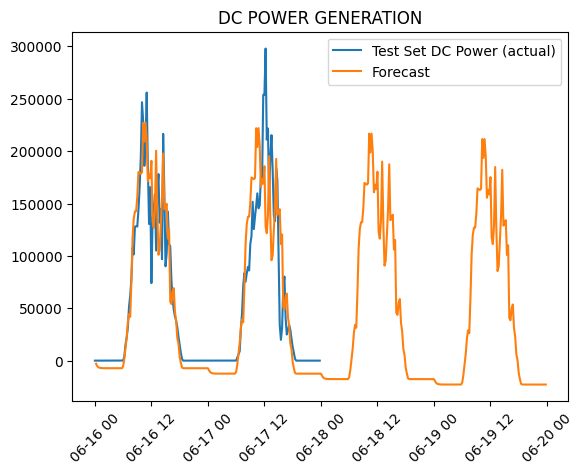

In [12]:
plt.plot(test_arima.DC_POWER,label='Test Set DC Power (actual)')
plt.plot(prediction_test, label='Forecast')
#plt.plot(prediction_future, label='Future Generation')
plt.xticks(rotation=45)
plt.title('DC POWER GENERATION')
plt.legend()
plt.show()



### 2.4 Evaluation: Comparing ARIMA and Prophet